<a href="https://colab.research.google.com/github/Rotem2411/alephBERTgimmelDalet/blob/main/word_embedding2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
file_path = 'sentiments.csv'
df = pd.read_csv(file_path)

Convert words to embeddings without text cleaning, using Word2Vec model

In [3]:
docs = df['text'].tolist()
tokenized_text = [nltk.word_tokenize(text) for text in docs]
model = Word2Vec(tokenized_text, min_count=1, vector_size=20, window=5)

Example of most similar words to 'נתניהו'

In [27]:
display(model.wv.most_similar('נתניהו', topn=10))

[('לפיד', 0.9627166390419006),
 ('פוטין', 0.9619266986846924),
 ('בנט', 0.9564189314842224),
 ('טראמפ', 0.9546679854393005),
 ('הליכוד', 0.9510836601257324),
 ('ביבי', 0.9479105472564697),
 ('ליברמן', 0.939850926399231),
 ('האוצר', 0.9330137372016907),
 ('כחלון', 0.9323013424873352),
 ('העם', 0.9291386008262634)]

Document Vectors from Word Embedding

In [4]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorized_text = vectorize(tokenized_text, model=model)
len(vectorized_text), len(vectorized_text[0])

(52184, 20)

We start by generating the blobs of data to be clustered

In [7]:
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=len(vectorized_text), centers=centers, cluster_std=0.7)

Compute clustering with KMeans

In [30]:
k_means = KMeans(n_clusters=4, n_init='auto')
X = np.array(vectorized_text)
k_means.fit(X)

KMeans(n_clusters=4, n_init='auto')

In [31]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

Plotting the results

[]

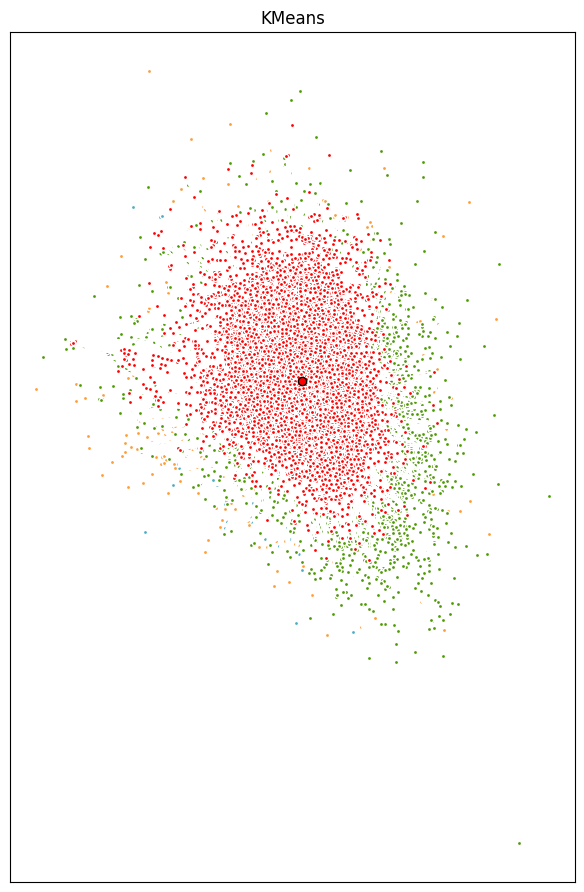

In [34]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06","#FF0000"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())

In [8]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)

print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster id labels for inputted data
[3 3 1 ... 1 1 1]
Centroids data
[[-1.04976359 -1.05500491]
 [-1.03333447  1.05863531]
 [ 1.04741129 -1.04194171]
 [ 1.04805518  1.05003979]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-40717.980940136345


Apply K-means clustering

In [ ]:
word_vectors = model.wv.vectors
kmeans = KMeans(n_clusters=4, n_init='auto').fit(word_vectors)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of elements assigned to each cluster: {cluster_sizes}")

Number of elements assigned to each cluster: [94881  8699   935  2404]


Reduce dimensionality to two dimensions using T-SNE

In [ ]:
arrays = np.empty((0, 300), dtype='f')
word_labels = [word]
color_list  = ['red']

# adds the vector of the query word
arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

# gets list of most similar words
close_words = model.wv.most_similar([word])

# adds the vector for each of the closest words to the array
for wrd_score in close_words:
  wrd_vector = model.wv.__getitem__([wrd_score[0]])
  word_labels.append(wrd_score[0])
  color_list.append('blue')
  arrays = np.append(arrays, wrd_vector, axis=0)

# adds the vector for each of the words from list_names to the array
for wrd in list_names:
  wrd_vector = model.wv.__getitem__([wrd])
  word_labels.append(wrd)
  color_list.append('green')
  arrays = np.append(arrays, wrd_vector, axis=0)

# Reduces the dimensionality from 300 to 50 dimensions with PCA
reduc = PCA(n_components=20).fit_transform(arrays)

# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

In [ ]:
tsne = TSNE(n_components=2, angle=0.2, perplexity=30, learning_rate=200, n_iter=250)
tsne_results = tsne.fit_transform(word_vectors)

Visualize t-SNE representations of the most common words

In [ ]:
# prompt: Display on graph/plot the results based on the clustering performed in k-mins before

# Create a scatter plot with different colors for each cluster
plt.figure(figsize=(10, 7))
for i in range(len(tsne_results)):
  plt.scatter(tsne_results[i, 0], tsne_results[i, 1], c=kmeans.labels_[i], alpha=0.5)
plt.title('Visualization of Word Clusters using T-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(cluster_ids)
plt.show()